In [1]:
import numpy as np
from matplotlib import pyplot as plt

#import renamed libraries from the numerical toolbox
from local_signal import *
from general import *

import scipy.io.wavfile as wav
from IPython.display import Audio

Problem:

$\hat{a} = argmin_a ||a||_0 $, s.t.

$||y^r - M^r \phi a||_2^2 \leq \epsilon $

$a \in C^N$ : Synthesis coefficients

$\phi in C^{TxN}$ synthesis operator, Gabor Frames (STFT) is well suited for audio signals, therefore $\phi$ represents the matrix associated with the Gabor dictionary

$y^r = M^r y \in R^M$ the reliable samples

$y \in R^T $ the observed signal

$M^r \in R^{MxT} $ matrix comprised of those rows in the identity matrix that chooses the entries of reliable samples

$M^c \in R^{(T-M)xT} $ the matrix choosing the clipped samples,

$\theta^{clip} \in R^{(T-M)} $ the vector  of clipped samples which can only have values $\pm \theta^{clip}$

Problem becomes:

$ \hat{a} = argmin_a ||a||_0 $, s.t.

$ ||y^r - M^r \phi a||^2_2 \leq \epsilon $ and $ |M^c \phi a| \geq |\theta^{clip}|$

With the squared hinge function:

$ h^2 : R \to R_+, z \to    h^2(z) = z^2 , :if z \lt 0, else:  0$

if $ z = x - \theta^{clip} for \theta^{clip} \gt 0$,

squared hinge sets x "free" if $|x| \geq \theta^{clip}$, so we can use the notation:

$[\theta^{clip} - x]^2_+ = \sum_{k:\theta^{clip}_k\gt 0} h^2(x_k - \theta^{clip}_k) + \sum_{k:\theta^{clip}_k\lt 0} h^2(\theta^{clip}_k - x_k) $

unconstrained convex optimization problem:

$ argmin_a \frac{1}{2} ||y^r - M^r \phi a||^2_2 + \frac{1}{2} [\theta^{clip} - M^c \phi a]^2_+ + \lambda||a||_1$

Additionally:

$\phi$: tight Gabor frame as time-frequency dictionary

$\phi*$: The corresponding analysis operator aka Sliding Window or STFT;

$\gamma$: 0.9



In [2]:
def squared_hinge_clipped(x, clipping_value):
    """ 
    Computes the squared hinge loss with clipping.
    """
    mask_below = x < -clipping_value
    sum_below = np.sum((clipping_value - x)[mask_below]**2)
    mask_above = x > clipping_value
    sum_above = np.sum((x - clipping_value)[mask_above]**2)
    return sum_below + sum_above

In [44]:
music_rate, music_signal = wav.read('music.wav')
# convert music_signal to float and normalize to [-1, 1]
music_signal = music_signal.astype(np.float32) / np.max(np.abs(music_signal))
# display music object
Audio(music_signal, rate=music_rate)

In [47]:
# clip signal to values between -20000, 20000
music_signal_clipped = np.clip(music_signal, -0.3, 0.3)
Audio(music_signal_clipped, rate=music_rate)


In [48]:
Jmin = 2

In [49]:
#import istft, stft
from scipy.signal import istft, stft
Psi = lambda a: istft(a, fs=music_rate, nperseg=1024, noverlap=512)[1]
PsiS = lambda a: stft(a, fs=music_rate, nperseg=1024, noverlap=512)[2]

In [233]:
def lasso_shrinkage(x, lambda_):
    """ 
    Computes the soft-thresholding operator.
        x: input signal in the time-frequency domain
        lambda_: threshold
    """ 
    result = 1 - lambda_ / np.abs(x)
    result[result < 0] = 0
    return result * x

def empirical_weiner(x, lambda_):
    """ 
    Computes the empirical Wiener filter.
        x: input signal in the time-frequency domain
        lambda_: threshold
    """ 
    result = 1 - lambda_**2 / np.abs(x)**2
    result[result < 0] = 0
    return result * x


$a^{(0)} \in C^N, z^{(0)} = a^{(0)}, k = 1, \delta = ||\phi \phi^*|| $

repeat:

$ g1 = -\phi^*M^{r^T}(y^r - M^r \phi z^{(k-1)})$

$ g2 = -\phi^* M^{c^T} [\theta^{clip} - M^c \phi z^{(k-1)}]_+ $

$ a^{(k)} = S_{\lambda / \delta} ( z^{(k-1)} - \frac{1}{\delta}(g1+g2))$

$ z^{(k)} = a^{(k)} + \gamma (a^{(k)} - a^{(k-1)})$

$ k = k + 1 $

until convergence

In [234]:
def snr(signal, computed_signal, mask=None):
    """ 
    Computes the signal to noise ratio. If a mask is provided, the SNR is computed only on the masked part of the signal.
    """
    if mask is None:
        return 20 * np.log10(np.sum(signal) / np.sum(signal - computed_signal))
    return 20 * np.log10(np.sum(signal[mask]) / np.sum((signal[mask] - computed_signal[mask])))

In [251]:
def declipping_ista(clipped_audio, clip_threshold, gamma, thresholding_function, lambdas_, n_iter=1000, i_between_lambdas=500):
    """ 
    Performs declipping using relaxed ISTA.
    assumption: delta = 1
    """
    lambda_i = 0
    lambda_ = lambdas_[lambda_i]

    audio_length = len(clipped_audio)
    #Mr: mask of unclipped values (reliable samples)
    #Mc: mask of clipped values
    values_below = clipped_audio < clip_threshold
    values_above = clipped_audio > -clip_threshold
    Mr = values_below * values_above
    Mc = ~Mr

    theta_clip = clipped_audio[Mc]
    #yr: reliable samples
    yr = clipped_audio[Mr]

    # initialize alpha, z
    frequency_domain = PsiS(clipped_audio)
    alpha = np.zeros_like(frequency_domain)
    alpha_prev = alpha.copy()
    z = alpha.copy()
    z_prev = z.copy()+1
    
    i_between_lambdas_start = 0
    # ISTA loop
    for i in range(n_iter):
        if i % 100 == 0:
            #this section is using signal that the algorithm should not have access to; it's just for monitoring progress
            computed_snr = snr(music_signal, Psi(z)[:audio_length], mask=Mc)
            print('Iteration: ', i, ' SNR: ', computed_snr)
        g1 = Psi(z)[:audio_length]
        g1 = g1[Mr]
        g1 = yr - g1
        temp_g1 = np.zeros_like(clipped_audio)
        temp_g1[Mr] = g1
        g1 = -PsiS(temp_g1)

        g2 = Psi(z)[:audio_length]
        g2 = g2[Mc]
        
        #this will be ugly
        #########
        #g2 = np.abs(theta_clip) - np.abs(g2) ###something fishy here??? 
        # if g2 is negative and theta_clip is negative but smaller in magnitude, we want to set g2 to 0
        # if g2 is positive and theta_clip is positive but smaller in magnitude, we want to set g2 to 0
        
        temp_g2 = np.copy(g2)

        mask_negative_theta_clip = theta_clip < 0
        mask_positive_theta_clip = theta_clip > 0
        negative_theta_clip = theta_clip.copy()
        negative_theta_clip[mask_positive_theta_clip] = 0
        positive_theta_clip = theta_clip.copy()
        positive_theta_clip[mask_negative_theta_clip] = 0

        # mask_g2_below_negative_theta_clip = g2 < negative_theta_clip
        # mask_g2_above_positive_theta_clip = g2 > positive_theta_clip
        # g2[mask_g2_below_negative_theta_clip] = 0
        # g2[mask_g2_above_positive_theta_clip] = 0

        temp_g2[mask_negative_theta_clip] = theta_clip[mask_negative_theta_clip] - g2[mask_negative_theta_clip]
        temp_g2[mask_positive_theta_clip] = g2[mask_positive_theta_clip] - theta_clip[mask_positive_theta_clip]
        g2 = temp_g2

        ############
        #this was ugly

        g2 = -np.min(g2, 0)
        temp_g2 = np.zeros_like(clipped_audio)
        temp_g2[Mc] = g2
        g2 = -PsiS(temp_g2)

        alpha = thresholding_function(z - (1./1.) * (g1 + g2), lambda_)
        z = alpha + gamma*(alpha - alpha_prev)
        alpha_prev = alpha.copy()
        #check if we have converged
        if np.allclose(z, z_prev) or i - i_between_lambdas_start == i_between_lambdas:
            if i - i_between_lambdas_start == i_between_lambdas:
                print("Changing current lambda because of too many iterations")
            print('Reached iteration ', i, ' with lambda = ', lambda_, ' and SNR (masked) = ', snr(music_signal, Psi(z)[:audio_length], mask=Mc).round(2), ' and SNR (unmasked) = ', snr(music_signal, Psi(z)[:audio_length]).round(2))
            if lambda_i == len(lambdas_) - 1:
                break
            lambda_i += 1
            lambda_ = lambdas_[lambda_i]
            i_between_lambdas_start = i

        z_prev = z.copy()
            
    unclipped_audio = Psi(z)[:audio_length]
    # replace reliable samples with original values
    unclipped_audio_replaced = unclipped_audio.copy()
    unclipped_audio_replaced[Mr] = clipped_audio[Mr]
    return unclipped_audio, unclipped_audio_replaced

In [252]:
clip_threshold = 0.2
clipped_audio = np.clip(music_signal, -clip_threshold, clip_threshold)
gamma = 0.9
# thresholding_function = lasso_shrinkage
thresholding_function = empirical_weiner
# lambdas_ = np.logspace(-1, -1.1, 2)
lambdas_ = [1e-1, 9e-2, 8.5e-2, 8e-2]

n_iter = 10000
i_between_lambdas = 200

unclipped_audio, unclipped_audio_replaced = declipping_ista(clipped_audio, clip_threshold, gamma, thresholding_function, lambdas_, n_iter, i_between_lambdas)


Iteration:  0  SNR:  0.0


C:\Users\deus-diabolus\AppData\Local\Temp\ipykernel_19072\2460023790.py:17: RuntimeWarning: overflow encountered in square
  result = 1 - lambda_**2 / np.abs(x)**2
C:\Users\deus-diabolus\AppData\Local\Temp\ipykernel_19072\3325062637.py:78: RuntimeWarning: overflow encountered in add
  z = alpha + gamma*(alpha - alpha_prev)


Iteration:  100  SNR:  nan
Iteration:  200  SNR:  nan
Changing current lambda because of too many iterations
Reached iteration  200  with lambda =  0.1  and SNR (masked) =  nan  and SNR (unmasked) =  nan
Iteration:  300  SNR:  nan
Iteration:  400  SNR:  nan
Changing current lambda because of too many iterations
Reached iteration  400  with lambda =  0.09  and SNR (masked) =  nan  and SNR (unmasked) =  nan
Iteration:  500  SNR:  nan


KeyboardInterrupt: 

In [227]:
# display unclipped audio
Audio(unclipped_audio_replaced, rate=music_rate)

In [145]:
unclipped_audio

array([ 0.00564193, -0.00463892, -0.01253761, ..., -0.04701605,
        0.00608074,  0.04403837], dtype=float32)

In [146]:
clipped_audio

array([ 0.00564193, -0.00463892, -0.01253761, ..., -0.04701605,
        0.00608074,  0.04403837], dtype=float32)

In [147]:
Audio(clipped_audio, rate=music_rate)

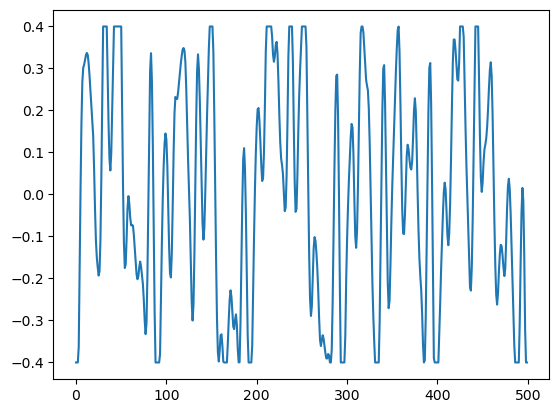

In [231]:
interval = 81000
plt.plot(clipped_audio[interval:interval+500])

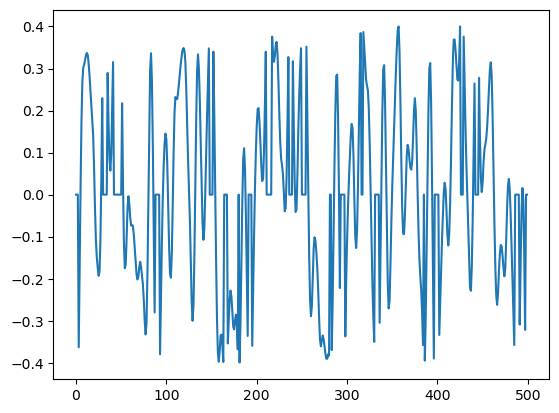

In [232]:
plt.plot(unclipped_audio_replaced[interval:interval+500])